<a href="https://colab.research.google.com/github/yasirgunes/wind_power_estimation/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import necessary libraries and implement preprocessing**
---

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import seaborn as sns
import os # for path manipulation
import sys # for path manipulation
from sklearn.preprocessing import StandardScaler

In [39]:
sys.path.append('drive/MyDrive/Wind Power Estimation')
from data_analysis import implement_data_preprocessing

In [40]:
aliaga_data, camlica_data, bursa_data, balikesir_data = implement_data_preprocessing()

**Visualize the wind power data**
---



<Axes: xlabel='date'>

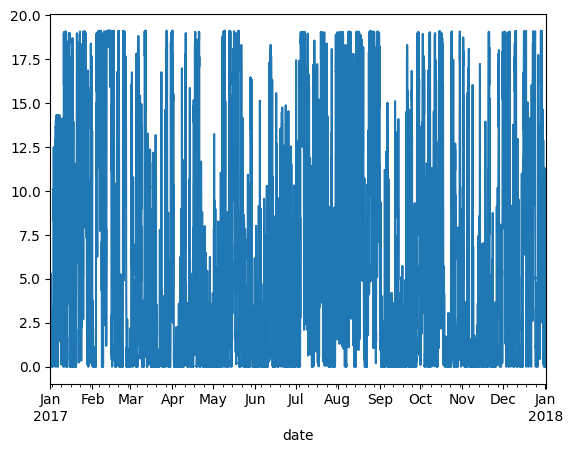

In [41]:
wind_data = aliaga_data["wind"][:"20180101"]
wind_data.plot()

In [42]:
aliaga_data.head()

,wind,ws10m,wd10m,ws50m,wd50m,rh2m,ps,prectotcorr,t2m,t2mdew,t2mwet
date,,,,,,,,,,,
2017-01-01 00:00:00,4.23,2.10,52.57,3.95,52.00,100.00,98.41,0.0,-5.10,-4.78,-4.94
2017-01-01 01:00:00,3.37,2.07,63.05,3.77,62.48,100.00,98.39,0.0,-4.84,-5.06,-4.95
2017-01-01 02:00:00,5.15,2.73,69.90,3.59,69.63,97.00,98.39,0.0,-4.47,-5.27,-4.87
2017-01-01 03:00:00,1.68,2.79,72.93,3.50,72.86,94.44,98.37,0.0,-4.35,-5.48,-4.92
2017-01-01 04:00:00,1.72,2.86,73.84,3.59,73.97,92.94,98.34,0.0,-4.35,-5.66,-5.00


**Setup the model**
---
- It will use sliding window approach
- It will for example take 5 hour input one by one and then predict the 6th hour.
- The model will be trained this way. It may take 24 hour as input and can predict the 1 hour later. It will be tentative.


In [43]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Sequence

**Expanding Window Approach**
---



In [44]:
class ExpandingWindowSequence(Sequence):
    """
    An advanced sequence generator that implements expanding window validation.
    This generator starts with a base window of data and gradually expands it
    during training, allowing the model to learn from increasingly more data
    patterns over time.

    The expansion happens by increasing the validation window size after each
    epoch, giving the model access to more diverse scenarios as training progresses.
    """
    def __init__(self, data, input_window, prediction_horizon, batch_size=32,
                 initial_window_size=None, expansion_rate=0.1):
        """
        Initialize the expanding window sequence generator.

        Parameters:
        -----------
        data : pd.DataFrame
            The complete dataset
        input_window : int
            Number of time steps to use as input
        prediction_horizon : int
            How many steps ahead to predict
        batch_size : int
            Size of each batch
        initial_window_size : int
            Size of the initial validation window (in data points)
        expansion_rate : float
            Rate at which to expand the window after each epoch
        """
        super().__init__()
        self.data = data
        self.input_window = input_window
        self.prediction_horizon = prediction_horizon
        self.batch_size = batch_size

        # Initialize window parameters
        self.initial_window_size = (initial_window_size if initial_window_size
                                  else len(data) // 4)  # Start with 25% of data
        self.current_window_size = self.initial_window_size
        self.expansion_rate = expansion_rate

        # Calculate sequences based on current window
        self.update_sequences()

        # Get feature names (all columns except target)
        self.feature_names = [col for col in data.columns if col != 'wind']

    def update_sequences(self):
        """Update the number of sequences based on current window size"""
        self.n_sequences = min(
            self.current_window_size - self.input_window - self.prediction_horizon + 1,
            len(self.data) - self.input_window - self.prediction_horizon + 1
        )

    def expand_window(self):
        """Expand the window size for the next epoch"""
        expansion_size = int(self.initial_window_size * self.expansion_rate)
        self.current_window_size = min(
            self.current_window_size + expansion_size,
            len(self.data)
        )
        self.update_sequences()

    def __len__(self):
        """Return the number of batches per epoch"""
        return int(np.ceil(self.n_sequences / self.batch_size))

    def __getitem__(self, idx):
        """Generate one batch of data"""
        batch_start = idx * self.batch_size
        batch_end = min((idx + 1) * self.batch_size, self.n_sequences)

        batch_size = batch_end - batch_start
        X_batch = np.zeros((batch_size, self.input_window, len(self.feature_names)))
        y_batch = np.zeros(batch_size)

        for i in range(batch_size):
            sequence_start = batch_start + i
            sequence_end = sequence_start + self.input_window

            X_batch[i] = self.data[self.feature_names].iloc[sequence_start:sequence_end].values

            target_idx = sequence_end + self.prediction_horizon - 1
            y_batch[i] = self.data['wind'].iloc[target_idx]

        return X_batch, y_batch

class ExpandingWindowCallback(tf.keras.callbacks.Callback):
    """
    Custom callback to handle the expansion of the validation window after each epoch.
    This callback works with the ExpandingWindowSequence to gradually increase
    the amount of validation data available during training.
    """
    def __init__(self, val_sequence):
        super().__init__()
        self.val_sequence = val_sequence

    def on_epoch_end(self, epoch, logs=None):
        """Expand the validation window after each epoch"""
        self.val_sequence.expand_window()
        print(f"\nValidation window size expanded to: {self.val_sequence.current_window_size}")

def prepare_data_for_expanding_window(data, input_window, prediction_horizon,
                                      initial_window_size=None, batch_size=32,
                                      feature_scaler=None, target_scaler=None):
    """
    Prepares data for expanding window validation.
    """
    # Use provided scalers or create new ones
    if feature_scaler is None:
        feature_scaler = StandardScaler()
    if target_scaler is None:
        target_scaler = StandardScaler()

    # Scale features and target
    feature_names = [col for col in data.columns if col != 'wind']
    scaled_features = feature_scaler.fit_transform(data[feature_names])
    scaled_target = target_scaler.fit_transform(data[['wind']])

    # Create scaled dataframe
    scaled_data = pd.DataFrame(scaled_features, columns=feature_names)
    scaled_data['wind'] = scaled_target

    if initial_window_size is None:
        initial_window_size = len(data) // 4  # Default to 25% of data

    return ExpandingWindowSequence(
        scaled_data,
        input_window=input_window,
        prediction_horizon=prediction_horizon,
        batch_size=batch_size,
        initial_window_size=initial_window_size
    ), feature_scaler, target_scaler

def train_with_expanding_window(model, train_sequence, val_sequence, epochs=100):
    """
    Trains the model using expanding window validation.
    """
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True),
        ExpandingWindowCallback(val_sequence)
    ]

    history = model.fit(
        train_sequence,
        validation_data=val_sequence,  # Use separate validation data
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )

    return history

In [45]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization
import matplotlib.pyplot as plt
import numpy as np

In [46]:
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Input


def build_encoder_decoder_model(input_shape):
    """
    Creates an advanced bidirectional LSTM model for wind power prediction.

    This model implements a sophisticated architecture using Bidirectional LSTM layers,
    which process sequences both forward and backward. This bidirectional approach
    allows the model to capture temporal patterns that might be missed when only
    processing in one direction, which is particularly valuable for wind power
    prediction where both leading and trailing weather patterns matter.

    The architecture includes:
    1. Two Bidirectional LSTM layers for deep feature extraction
    2. Batch normalization for training stability
    3. Dropout layers for preventing overfitting
    4. Dense layers for final prediction refinement

    Parameters:
    -----------
    input_shape : tuple
        Shape of input data in format (time_steps, features)
        Example: (48, 10) for 48 hours of historical data with 10 features

    Returns:
    --------
    model : tf.keras.Model
        Compiled bidirectional LSTM model ready for training

    Architecture Details:
    -------------------
    - First Bidirectional LSTM: 128 units (64 in each direction)
        Processes the input sequence in both directions to capture temporal dependencies

    - Second Bidirectional LSTM: 64 units (32 in each direction)
        Refines the features extracted by the first layer

    - Batch Normalization: After each LSTM layer
        Normalizes layer outputs to stabilize training and reduce internal covariate shift

    - Dropout (0.2): After each batch normalization
        Randomly deactivates 20% of units during training to prevent overfitting

    - Dense Layers: Final prediction refinement
        Converts processed features into wind power predictions

    Notes:
    ------
    - The model uses 'tanh' activation in LSTM layers (default) which is suitable
      for capturing both positive and negative patterns in wind power changes
    - ReLU activation in dense layers helps capture non-linear relationships
    - Learning rate is set to 0.001 for stable training
    """
    model = Sequential([
        Input(shape=input_shape),
        Bidirectional(LSTM(128, return_sequences=True)),
        BatchNormalization(),
        Dropout(0.2),
        Bidirectional(LSTM(64, return_sequences=True)),  # Added another layer
        BatchNormalization(),
        Dropout(0.2),
        Bidirectional(LSTM(32)),  # Final layer
        BatchNormalization(),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])

    # Configure optimizer with reduced learning rate for stability
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    # Compile model with mean squared error loss and mean absolute error metric
    model.compile(
        optimizer=optimizer,
        loss='mse',  # Mean Squared Error for regression
        metrics=['mae']  # Mean Absolute Error for interpretability
    )

    return model

In [47]:
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

def evaluate_model_performance(model, val_gen, target_scaler, num_samples=None):
    """
    Evaluates the model's performance using multiple metrics and visualization.

    This function:
    1. Collects predictions and actual values from the validation generator
    2. Calculates R², RMSE, MSE, and MAE
    3. Creates visualization of predicted vs actual values
    4. Prints a detailed performance report

    Parameters:
    -----------
    model : tf.keras.Model
        The trained model to evaluate
    val_gen : WindPowerSequence
        Validation data generator
    num_samples : int, optional
        Number of samples to evaluate (defaults to entire validation set)

    Returns:
    --------
    dict
        Dictionary containing all computed metrics
    """
    # Collect predictions and actual values
    true_values = []
    predictions = []

    # If num_samples not specified, use all available samples
    if num_samples is None:
        num_samples = len(val_gen) * val_gen.batch_size

    samples_collected = 0

    # Collect predictions batch by batch
    for i in range(len(val_gen)):
        if samples_collected >= num_samples:
            break

        X_batch, y_batch = val_gen[i]
        batch_predictions = model.predict(X_batch, verbose=0)

        true_values.extend(y_batch)
        predictions.extend(batch_predictions.flatten())

        samples_collected += len(y_batch)

    # Convert lists to numpy arrays first
    true_values = np.array(true_values)
    predictions = np.array(predictions)

    # Now we can reshape and inverse transform
    true_values = target_scaler.inverse_transform(true_values.reshape(-1, 1)).flatten()
    predictions = target_scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()

    # Calculate metrics
    r2 = r2_score(true_values, predictions)
    mse = mean_squared_error(true_values, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true_values, predictions)

    # Create visualizations
    plt.figure(figsize=(15, 5))

    # Time series plot
    plt.subplot(1, 2, 1)
    plt.plot(true_values, label='Actual', alpha=0.7)
    plt.plot(predictions, label='Predicted', alpha=0.7)
    plt.title('Actual vs Predicted Wind Power')
    plt.xlabel('Time Step')
    plt.ylabel('Wind Power')
    plt.legend()

    # Scatter plot
    plt.subplot(1, 2, 2)
    plt.scatter(true_values, predictions, alpha=0.5)
    plt.plot([true_values.min(), true_values.max()],
             [true_values.min(), true_values.max()],
             'r--', label='Perfect Prediction')
    plt.title('Predicted vs Actual Values')
    plt.xlabel('Actual Wind Power')
    plt.ylabel('Predicted Wind Power')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Print detailed report
    print("\nModel Performance Metrics:")
    print("-------------------------")
    print(f"R² Score: {r2:.4f} {'✓' if r2 > 0.7 else '✗'} (Target: > 0.7)")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")

    if r2 > 0.7:
        print("\n✓ Model meets the R² requirement (> 0.7)")
    else:
        print("\n✗ Model does not meet the R² requirement (> 0.7)")
        print("Consider applying some improvements:")
        print("1. Increase the input window size")
        print("2. Add batch normalization")
        print("3. Adjust the model architecture")
        print("4. Feature selection/engineering")

    return {
        'r2': r2,
        'rmse': rmse,
        'mse': mse,
        'mae': mae,
        'predictions': predictions,
        'true_values': true_values
    }

In [48]:
def evaluate_on_other_windfarm(model, test_data, feature_scaler, target_scaler, input_window=8, batch_size=32):
    """
    Evaluate the trained model on another wind farm dataset.
    """
    # Scale the test data using the same scalers as training
    feature_names = [col for col in test_data.columns if col != 'wind']
    scaled_features = feature_scaler.transform(test_data[feature_names])
    scaled_target = target_scaler.transform(test_data[['wind']])

    # Create scaled dataframe
    scaled_test_data = pd.DataFrame(scaled_features, columns=feature_names)
    scaled_test_data['wind'] = scaled_target

    # Create test sequence
    test_sequence = ExpandingWindowSequence(
        scaled_test_data,
        input_window=input_window,
        prediction_horizon=1,
        batch_size=batch_size
    )

    # Collect predictions and actual values
    true_values = []
    predictions = []

    for i in range(len(test_sequence)):
        X_batch, y_batch = test_sequence[i]
        batch_predictions = model.predict(X_batch, verbose=0)

        true_values.extend(y_batch)
        predictions.extend(batch_predictions.flatten())

    # Inverse transform the predictions and actual values
    true_values = target_scaler.inverse_transform(np.array(true_values).reshape(-1, 1)).flatten()
    predictions = target_scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

    # Calculate metrics
    r2 = r2_score(true_values, predictions)
    mse = mean_squared_error(true_values, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true_values, predictions)

    print(f"\nModel Performance on Test Wind Farm:")
    print(f"R² Score: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")

    return {
        'r2': r2,
        'rmse': rmse,
        'mse': mse,
        'mae': mae
    }


In [49]:
def plot_training_history(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def complete_wind_power_evaluation():
    """
    Implements the complete three-stage evaluation process from the paper:
    1. Train and validate on one wind farm
    2. Test on other well-established wind farms
    3. Test on newly-established wind farm
    """
    # Split aliaga_data into training and validation sets
    train_split = 0.8
    train_data = aliaga_data.iloc[:int(len(aliaga_data) * train_split)]
    val_data = aliaga_data.iloc[int(len(aliaga_data) * train_split):]

    # Prepare separate data sequences for training and validation
    train_sequence, feature_scaler, target_scaler = prepare_data_for_expanding_window(
        train_data, input_window=8, prediction_horizon=1, batch_size=32
    )
    val_sequence, _, _ = prepare_data_for_expanding_window(
        val_data, input_window=8, prediction_horizon=1, batch_size=32
    )

    # Build and train model
    input_shape = (8, len([col for col in aliaga_data.columns if col != 'wind']))
    model = build_encoder_decoder_model(input_shape)
    history = train_with_expanding_window(model, train_sequence, val_sequence, epochs=100)
    plot_training_history(history)

    # Stage 2: Test on other well-established wind farms
    print("\nStage 2: Testing on Other Well-established Wind Farms")

    print("\nTesting on Balikesir Wind Farm:")
    metrics = evaluate_on_other_windfarm(model, balikesir_data, feature_scaler, target_scaler)

    return metrics

Epoch 1/100
328/329 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.0819 - mae: 0.8228
Validation window size expanded to: 2893
329/329 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - loss: 1.0804 - mae: 0.8222 - val_loss: 0.7520 - val_mae: 0.6409
Epoch 2/100
326/329 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.5166 - mae: 0.5549
Validation window size expanded to: 3156
329/329 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - loss: 0.5170 - mae: 0.5551 - val_loss: 0.6861 - val_mae: 0.6206
Epoch 3/100
326/329 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.4799 - mae: 0.5275
Validation window size expanded to: 3419
329/329 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - loss: 0.4798 - mae: 0.5274 - val_loss: 0.6850 - val_mae: 0.6344
Epoch 4/100
326/329 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.4594 - mae: 0.5124
Validation window size expanded to: 3682
329/329 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - loss: 0.4593 - mae: 0.5124 - val_loss: 0.5944 - val_mae: 0.5924
Epoch 5/100
326/329 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.4080

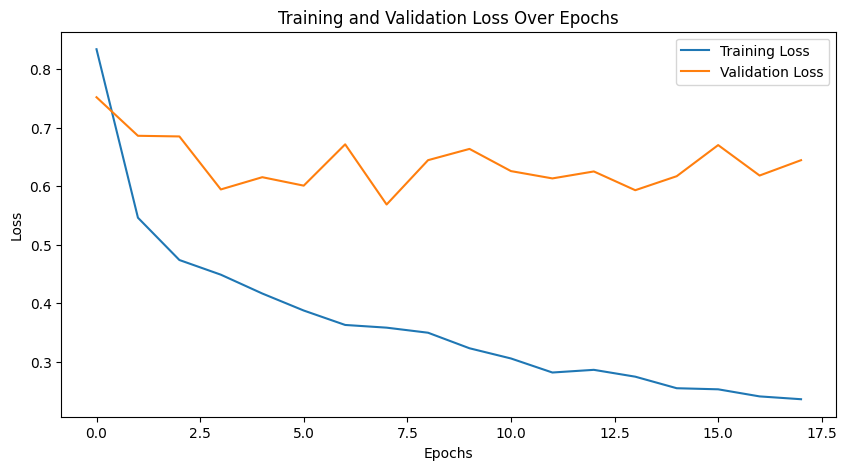


Stage 2: Testing on Other Well-established Wind Farms

Testing on Balikesir Wind Farm:

Model Performance on Test Wind Farm:
R² Score: -0.1952
RMSE: 7.0301
MSE: 49.4225
MAE: 6.2771


{'r2': -0.1951539386762764,
 'rmse': 7.03011560836025,
 'mse': 49.4225254669104,
 'mae': 6.277130460752196}

In [50]:
# run the evaluation
complete_wind_power_evaluation()